This is a notebook to produce the cached AGN and SN galaxy_id lists for DC2 Run 1.1.

In [1]:
import pandas as pd
from astropy.io import fits
import numpy as np
from desc.twinkles import sprinkler
from lsst.sims.utils import SpecMap
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spr = sprinkler('descqa_compound_cat.txt', 1000.0, SpecMap)

In [3]:
uddf_df = pd.read_csv('descqa_compound_cat.txt')

In [4]:
density_param = 0.76
agn_obj = uddf_df.query('objid == 117')
new_col = list(agn_obj.columns)
new_col[6] = 'mag_norm'
agn_obj.columns = new_col
agn_obj['mag_norm'] = np.array(agn_obj['mag_norm'].values, dtype=np.float)
agn_obj_bright = agn_obj.query('mag_norm < 30.')
agn_obj_bright = agn_obj_bright.reset_index(drop=True)

/global/common/software/lsst/common/miniconda/py3-4.2.12/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
list(agn_obj.columns)

['uniqueId',
 'objid',
 'galaxy_id',
 'raJ2000',
 'decJ2000',
 'redshift',
 'mag_norm']

In [10]:
print(len(agn_obj), len(agn_obj_bright), len(np.unique(uddf_df['uniqueId'])), agn_ob)

1052571 94067 3157713


In [34]:
no_agn = agn_obj.iloc[np.where(np.isnan(agn_obj['mag_norm'].values))[0]]

In [88]:
def find_agn_lens_candidates(galz, gal_mag):
        # search the OM10 catalog for all sources +- 0.1 dex in redshift                                                                                               
        # and within .25 mags of the CATSIM source                                                                                                                     
    w = np.where((np.abs(np.log10(spr.lenscat['ZSRC']) - np.log10(galz)) <= 0.1) &
                     (np.abs(np.array(spr.src_mag_norm) - gal_mag) <= .3))[0]
    lens_candidates = spr.lenscat[w]

    return lens_candidates

In [90]:
good_rows = []
ra_list = []
dec_list = []
gal_ids = []
sys_ids = []
for idx, row in agn_obj_bright.iterrows():
    if idx % 5000 == 0:
        print(idx)
    if not np.isnan(row['mag_norm']):
        if (52.495 < row['raJ2000'] < 53.755) and (-28.65 < row['decJ2000'] < -27.55):
            candidates = find_agn_lens_candidates(row['redshift'], row['mag_norm'])
            np.random.seed(np.int(row['galaxy_id']))
            pick_value = np.random.uniform()
            if ((len(candidates) > 0) and (pick_value <= density_param)):
                good_rows.append(idx)
                candidates = candidates[np.argsort(candidates['twinklesId'])]
                gal_ids.append(row['galaxy_id'])
                newlens = np.random.choice(candidates)
                sys_ids.append(newlens['twinklesId'])
                ra_list.append(row['raJ2000'])
                dec_list.append(row['decJ2000'])

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000


In [91]:
len(good_rows)

1028

In [62]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

/global/common/software/lsst/common/miniconda/py3-4.2.12/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


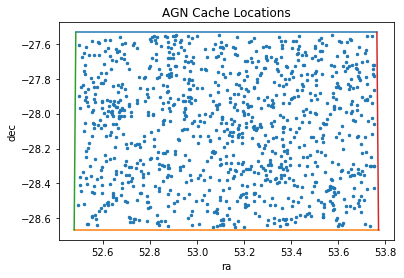

In [107]:
plt.scatter(ra_list, dec_list, s=6)
plt.plot((52.486, 53.764), (-27.533, -27.533))
plt.plot((52.479, 53.771), (-28.667, -28.667))
plt.plot((52.479, 52.486), (-28.667, -27.533))
plt.plot((53.771, 53.764), (-28.667, -27.533))
plt.xlabel(r'ra')
plt.ylabel(r'dec')
plt.title('AGN Cache Locations')
plt.savefig('agn_cache.png')

In [94]:
agn_cache = pd.DataFrame(np.array([gal_ids, sys_ids], dtype=np.int).T, columns=['galtileid', 'twinkles_system'])

In [95]:
agn_cache.to_csv('dc2_agn_cache.csv', index=False)

In [25]:
bulge_obj = uddf_df.query('objid == 97')
print(len(bulge_obj))
bulge_obj = bulge_obj.reset_index(drop=True)

1052571


In [96]:
sne_density = 0.055

In [89]:
bulge_no_agn = pd.merge(bulge_obj, no_agn, on='galaxy_id',suffixes=('', '_y'))

In [90]:
bulge_no_agn.head()

,uniqueId,objid,galaxy_id,raJ2000,decJ2000,redshift,minorAxis,uniqueId_y,objid_y,raJ2000_y,decJ2000_y,redshift_y,mag_norm
0,5374049,97,5248,52.3605,-28.5893,0.6375,0.0000,5374069,117,52.3605,-28.5893,0.6375,NaN
1,5408865,97,5282,52.5210,-28.5538,0.6276,0.2201,5408885,117,52.5210,-28.5538,0.6276,NaN
2,5415009,97,5288,52.3631,-28.6025,0.6375,0.0000,5415029,117,52.3631,-28.6025,0.6375,NaN
3,5422177,97,5295,52.3586,-28.5956,0.6375,0.0000,5422197,117,52.3586,-28.5956,0.6375,NaN
4,5427297,97,5300,52.5165,-28.5499,0.6276,0.0000,5427317,117,52.5165,-28.5499,0.6276,NaN


In [97]:
good_rows_sn = []
gal_ids_sn = []
sys_ids_sn = []
used_systems = []
ra_list_sn = []
dec_list_sn = []
total_unique_sys = len(np.unique(spr.sne_catalog['twinkles_sysno']))
for idx, row in bulge_no_agn.iterrows():
    if idx % 10000 == 0:
        print(idx, row['raJ2000'], row['decJ2000'])
    if (52.495 < row['raJ2000'] < 53.755) and (-28.65 < row['decJ2000'] < -27.55):
        lens_sne_candidates = spr.find_sne_lens_candidates(row['redshift'])
        candidate_sysno = np.unique(lens_sne_candidates['twinkles_sysno'])
        num_candidates = len(candidate_sysno)
        if num_candidates == 0:
            continue
        np.random.seed(np.int(row['galaxy_id']))
        pick_value = np.random.uniform()
        if pick_value <= sne_density:
            used_already = np.array([sys_num in used_systems for sys_num in candidate_sysno])
            unused_sysno = candidate_sysno[~used_already]
            if len(unused_sysno) == 0:
                continue
            use_system = np.random.choice(unused_sysno)
            good_rows_sn.append(idx)
            gal_ids_sn.append(row['galaxy_id'])
            sys_ids_sn.append(use_system)
            ra_list_sn.append(row['raJ2000'])
            dec_list_sn.append(row['decJ2000'])
            used_systems.append(use_system)
            if len(used_systems) == total_unique_sys:
                break

0 52.3605 -28.5893
10000 53.9636 -28.0065
20000 53.3187 -27.9654
30000 53.2187 -28.114
40000 53.1793 -27.8454


In [98]:
len(good_rows_sn), len(ra_list_sn), total_unique_sys

(953, 953, 953)

/global/common/software/lsst/common/miniconda/py3-4.2.12/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


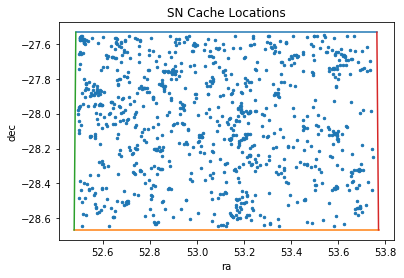

In [99]:
plt.scatter(ra_list_sn, dec_list_sn, s=6)
plt.plot((52.486, 53.764), (-27.533, -27.533))
plt.plot((52.479, 53.771), (-28.667, -28.667))
plt.plot((52.479, 52.486), (-28.667, -27.533))
plt.plot((53.771, 53.764), (-28.667, -27.533))
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('SN Cache Locations')
plt.savefig('sne_cache.png')

In [100]:
sne_cache = pd.DataFrame(np.array([gal_ids_sn, sys_ids_sn], dtype=np.int).T, columns=['galtileid', 'twinkles_system'])

In [101]:
sne_cache.to_csv('dc2_sne_cache.csv', index=False)

/global/common/software/lsst/common/miniconda/py3-4.2.12/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


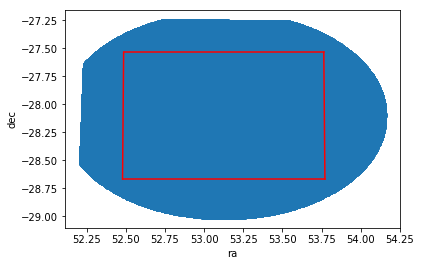

In [102]:
plt.scatter(uddf_df['raJ2000'], uddf_df['decJ2000'])
plt.plot((52.486, 53.764), (-27.533, -27.533), c='r')
plt.plot((52.479, 53.771), (-28.667, -28.667), c='r')
plt.plot((52.479, 52.486), (-28.667, -27.533), c='r')
plt.plot((53.771, 53.764), (-28.667, -27.533), c='r')
plt.xlabel('ra')
plt.ylabel('dec')